# Machine Learning Assignment Homework 1: Linear Models

## Introduction
In this notebook, I will create two regression based models to assess air quality.  
The target variable is the hourly averaged sensor response for CO.  
The notebook will cover the following steps:
- Data Processing
- Exploratory Data Analysis
- Linear Regression Implementation
- Logistic Regression Implementation
- Result Analysis - Linear Regression
- Result Analysis - Logistic Regression
- ROC Curve - Logistic Regression
- Inference - Linear and Logistic Regression

## (a) Data Processing

### Data Loading and Cleaning

In [1]:
import os
import pandas as pd

# Current working directory
cwd = os.getcwd()

# Relative paths
data_train_path = os.path.join(cwd, '..', 'data', 'data_train.csv')
data_test_path = os.path.join(cwd, '..', 'data', 'data_test.csv')

# Load the training data
data_train = pd.read_csv(data_train_path)

# Load the test data
data_test = pd.read_csv(data_test_path)

I used the `pandas` library and the `read_csv` function to load the train and test datasets.

In [2]:
# Display the first 5 rows
data_train.head()

,Unnamed: 0,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,797.0,-200.0,2.1,593.0,146.0,1212.0,72.0,984.0,494.0,10.8,49.7,0.6429
1,1,1282.0,-200.0,11.0,1013.0,354.0,545.0,141.0,1384.0,1287.0,17.4,50.6,0.9989
2,2,891.0,-200.0,7.6,882.0,342.0,885.0,149.0,950.0,894.0,7.8,33.9,0.3594
3,3,1285.0,-200.0,18.1,1243.0,481.0,599.0,173.0,1815.0,1582.0,26.4,41.9,1.4237
4,4,892.0,-200.0,7.3,869.0,71.0,953.0,77.0,1363.0,632.0,37.4,14.7,0.9295


In [3]:
# Print the shape of the training dataframe
print(f"\nShape of the training data: {data_train.shape}")
print(f"Column names: {data_train.columns.to_list()}")


Shape of the training data: (6250, 13)
Column names: ['Unnamed: 0', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


### Data Overview
The training data has 6250 rows and 13 columns.  
Each row of the data corresponds to a sample and columns denote the features.  
The column named `Unnamed: 0` just contains the index of the rows and will not be a part of our training data.  
So we have 11 columns representing features and 1 column representing the label (Target Variable: `PT08.S1(CO)`)  
So the 12 columns in our training data represent the following:
1. `NMHC(GT)`: hourly averaged overall Non Metanic HydroCarbons concentration in microg/m3
2. `C6H6(GT)`: hourly averaged Benzene concentration in microg/m3
3. `PT08.S2(NMHC)`: hourly averaged sensor response to NMHC
4. `NOx(GT)`: hourly averaged NOx concentration in ppb
5. `PT08.S3(NOx)`: hourly averaged sensor response for NOx
6. `NO2(GT)`: hourly averaged NO2 concentration in microg/m3
7. `PT08.S4(NO2)`: hourly averaged sensor response for NO2
8. `PT08.S5(O3)`: hourly averaged sensor response for O3
9. `T`: Temperature in C
10. `RH`: Relative Humidity
11. `AH`: Absolute Humidity
12. `PT08.S1(CO)`: **TARGET VARIABLE** - hourly averaged sensor response for CO

##### Data Cleaning

In [4]:
# Drop the 'Unnamed: 0' index column
data_train.drop(columns=['Unnamed: 0'], inplace=True)

# Check for missing values
missing_values = data_train.isnull().sum()
print("Number of missing values for each column in the training data:")
print(missing_values)
print(f"\nTotal number of missing values in the dataset: {missing_values.sum()}")

Number of missing values for each column in the training data:
PT08.S1(CO)      77
NMHC(GT)         77
C6H6(GT)         77
PT08.S2(NMHC)    77
NOx(GT)          77
PT08.S3(NOx)     77
NO2(GT)          77
PT08.S4(NO2)     77
PT08.S5(O3)      77
T                77
RH               77
AH               77
dtype: int64

Total number of missing values in the dataset: 924


In [5]:
# Drop rows with missing data in original dataframe using inplace=True
data_train.dropna(inplace=True)
print(f"Shape after dropping missing data: {data_train.shape}")


Shape after dropping missing data: (6173, 12)


##### Feature and Label Extraction

In [6]:
# Extract the features and the label
X_train = data_train.drop(columns=['PT08.S1(CO)'], inplace=False)
y_train = data_train['PT08.S1(CO)']

print(f"Features: {X_train.columns.tolist()}")
print(f"Label: {y_train.name}")

Features: ['NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
Label: PT08.S1(CO)


The features include all columns except the target variable `PT08.S1(CO)`.  
The target variable represents the hourly averaged sensor response for CO, which we aim to predict using regression models.

## (b) Exploratory Data Analysis

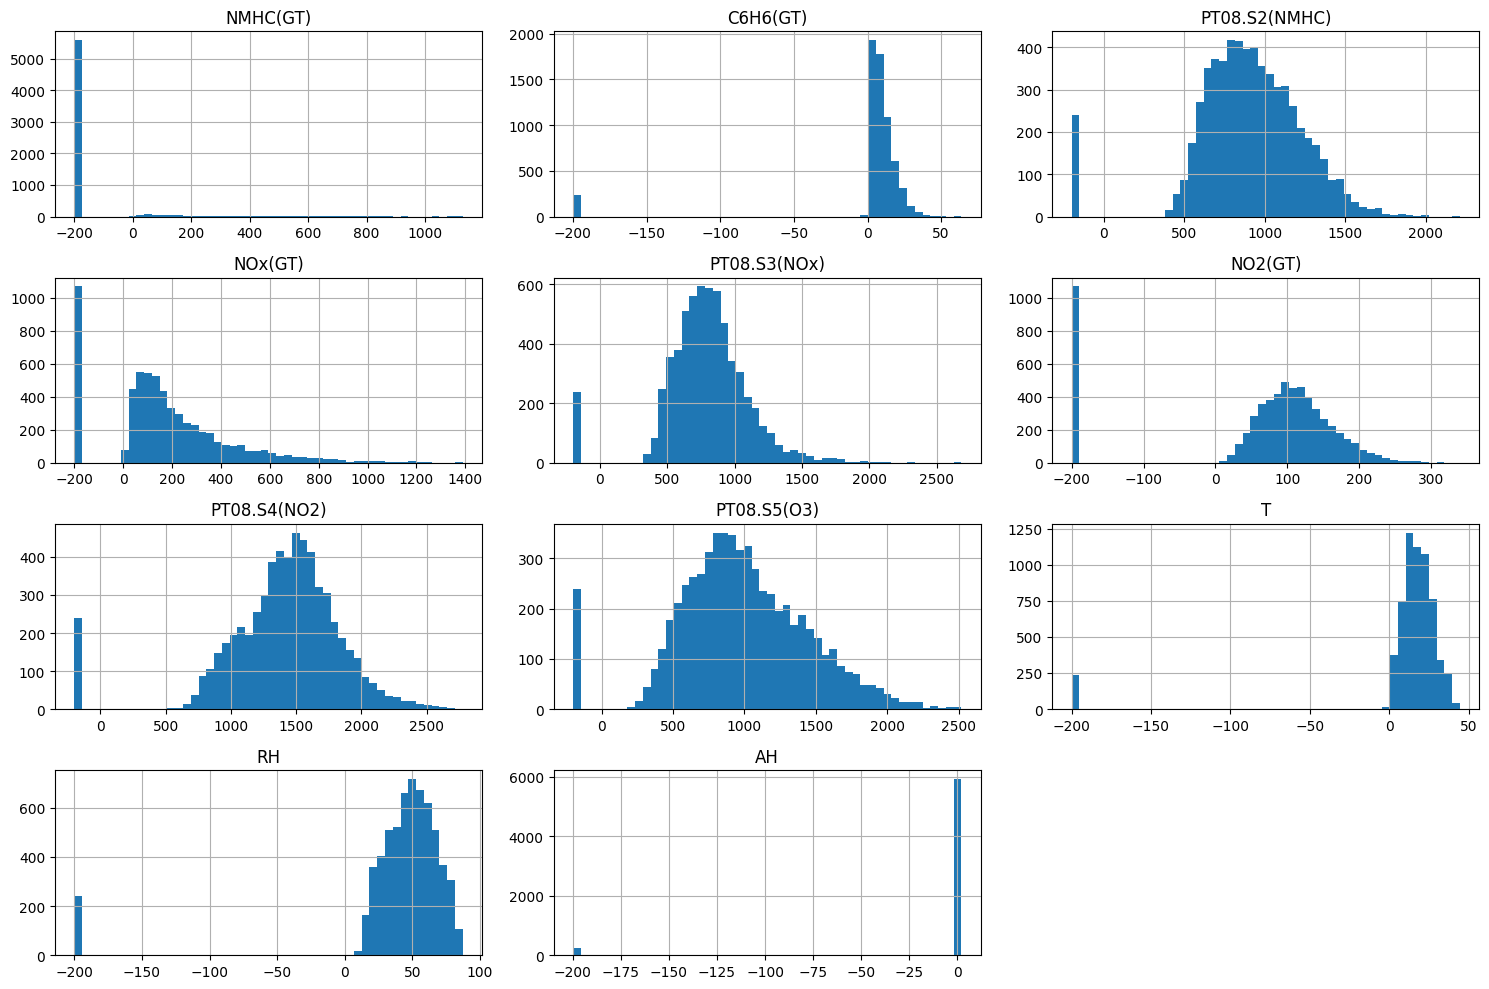

In [7]:
import matplotlib.pyplot as plt

# Plot histograms
X_train.hist(bins=50, figsize=(15, 10))
plt.tight_layout()
plt.show()

##### Feature Distributions
As we can see, not all the features have a normal distribution (although some of them have quite normal distribution except that they have outliers as well).
- Skewed distributions: For instance, features like C6H6(GT), NOx(GT) appear right skewed
- Outliers: Almost all the features show significant outliers. The extreme negative values on the left seem unusual. For example, Absolute Humidity(AH) should not be negative, which suggests that these outliers could be erroneous data. Similarly, Benzene(C6H6) or other concentration in air cannot be negative.

Normalization or transformation of features seems necessary based on what the histograms reveal. The reasons for this include:
- Normalization: Scaling the data to a specific range seems to be a good idea to handle these features with different scales or units for our models. Features like T(Temperature) and RH(Relative Humidity) have values with drastically different ranges from others, which might impact our model. So bringing features to a common scale ensures that no single feature dominates others.
- Handling outliers: We see there are outlier values in our training data, so standardisation (Z-score normalization) would be useful.

In [8]:
# Apply Z-score Normalization (Standardisation)
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_train

,NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,-0.289441,-0.000142,-0.897578,-0.102464,1.319430,0.100469,-0.892367,-1.065368,0.018261,0.198539,0.190623
1,-0.289441,0.215756,0.326564,0.700325,-0.764631,0.645347,-0.034754,0.662151,0.171651,0.216185,0.199801
2,-0.289441,0.133278,-0.055252,0.654010,0.297709,0.708521,-0.965264,-0.193984,-0.051461,-0.111235,0.183314
3,-0.289441,0.387989,0.996927,1.190489,-0.595906,0.898043,0.889324,1.304797,0.380819,0.045613,0.210753
4,-0.289441,0.126000,-0.093142,-0.391931,0.510177,0.139953,-0.079779,-0.764741,0.636468,-0.487670,0.198012
...,...,...,...,...,...,...,...,...,...,...,...
6244,-0.289441,0.058077,-0.477872,0.183144,0.678901,0.361063,-0.793742,-0.610070,-0.009628,0.280884,0.190613
6245,-0.289441,0.002284,-0.871346,-0.457543,1.088215,-0.120640,-0.135524,-0.849701,0.257642,0.474984,0.214826
6246,-0.289441,0.038671,-0.603201,-0.063868,0.269588,0.447927,-0.909519,-0.697208,-0.053785,0.263239,0.188414
6247,-0.289441,0.045948,-0.559481,-0.488420,0.647656,-0.049569,0.068159,-0.283301,0.325041,-0.034772,0.202606


##### Data Transformation
Normalization: I applied standardization (Z-score normalization) to ensure all features have the same scale, making the mean of each feature 0 and the standard deviation 1. This ensures that no feature dominates the regression models due to it's scale.  
I chose Z-score normalization over Max-Min Normalization because normalizing the data using Max-Min Normalization will scale most of the data to a small interval, which means all features have the same scale but it does not handle outliers well. Standardisation is more robust to outliers, so it is preferable over Max-Min Normalization for our case.  
Standardisation allows users to better handle the outliers and facilitate convergence for some computational algorithms like gradient descent, which we will be using for our model.

In [9]:
# COMMENTED THIS CELL TO REDUCE OVERALL RUNTIME

# import seaborn as sns
# import matplotlib.pyplot as plt

# df = data_train[['NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 
#                  'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 
#                  'T', 'RH', 'AH', 'PT08.S1(CO)']]

# sns.pairplot(df)
# plt.show()

Plotted the pair plot between all the feature pairs, then we pick 2 features `C6H6(GT)` and `PT08.S5(O3)`, and create a scatter plot to illustrate the correlation between these two features.  
`NOTE`: The code in the above cell to plot the pair plot has been commented to avoid higher runtime of the entire notebook.

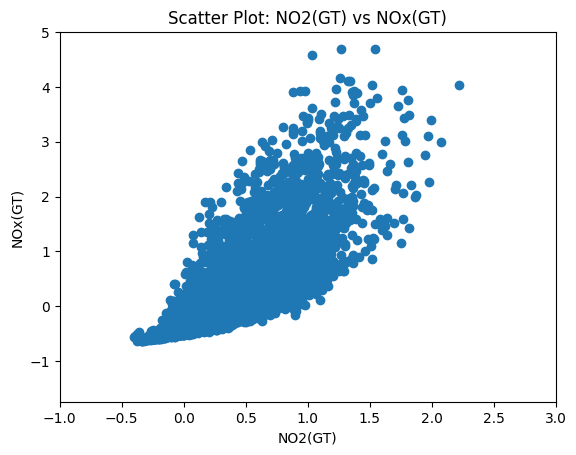

In [10]:
# Select two features
feature_1 = 'NO2(GT)'
feature_2 = 'NOx(GT)'

# Create scatter plot
plt.scatter(X_train[feature_1], X_train[feature_2])
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.title(f'Scatter Plot: {feature_1} vs {feature_2}')
plt.xlim(-1, 3)
plt.show()

#### Scatter Plot Analysis
The scatter plot between `NO2(GT)` and `NOx(GT)` shows a certain degree of correlation, indicating that as the concentration of NO2 increases, NOx concentration also tends to increase, which makes sense chemically as NOx compounds typically include NO2.

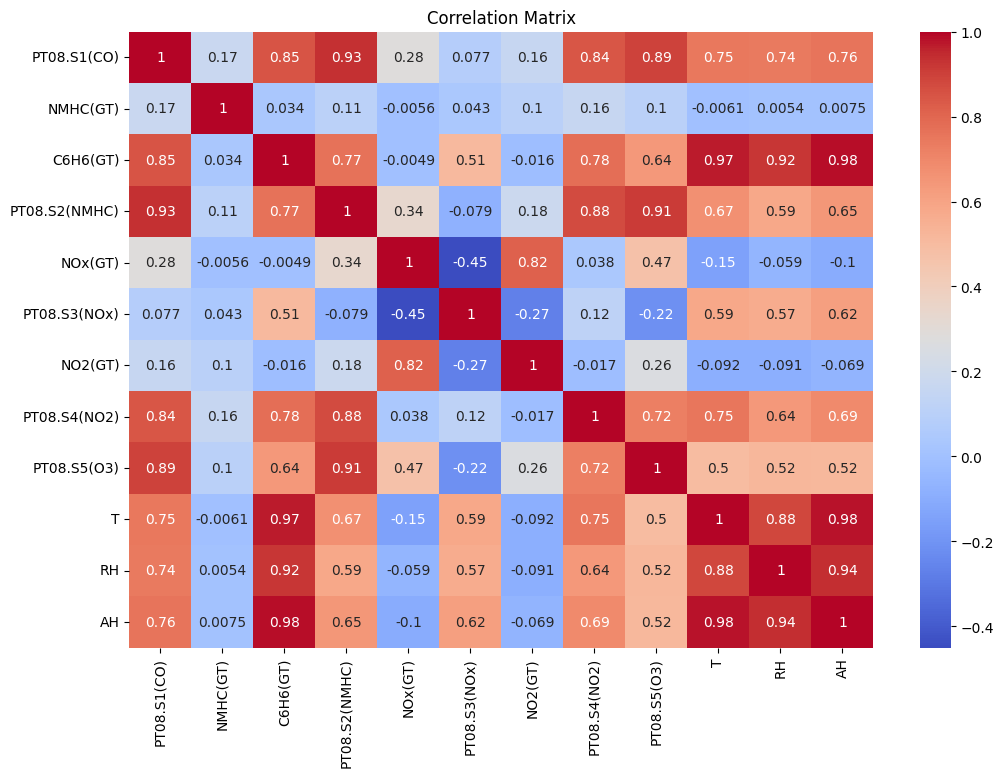

In [11]:
import seaborn as sns

# Compute correlation matrix
C = data_train.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(C, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Correlation Heatmap Analysis

The heatmap above represents the Pearson correlation between all pairs of variables in the training data. The values range from -1 to 1, with positive values indicating a positive correlation and negative values indicating a negative correlation. The color intensity corresponds to the strength of the correlation. Cells with higher positive correlations will have colors closer to red, while negative correlations will be blue.

#### Key Observations:
1. **Strong Positive Correlation**:
    - **Target Variable**: We can see that our target variable `PT08.S1(CO)` is quite strongly correlated to some features like `PT08.S2(NMHC)` (0.93), `PT08.S5(O3)` (0.89), `C6H6(GT)` (0.85) and `PT08.S4(NO2)` (0.84).
    - `PT08.S2(NMHC)` and `PT08.S5(O3)`: These sensors are strongly correlated (0.91), which suggest that these sensors might be detecting similar environmental factors. This might also indicate potential sensor redundancy.
    - `PT08.S2(NMHC)` is strongly correlated with `PT08.S4(NO2)` (0.88), indicating that there is some relationship between the sensor values for NMHC and NO2, which could be related to common air pollution sources. This might also indicate potential sensor redundancy.
    - We can also see that `C6H6(GT)` is very strongly related to `Temperature(T)`, `Absolute Humidity(AH)` and `Relative Humidit(RH)` with a value of 0.97, 0.98 and 0.92 respectively, indicating that increase in the Benzene concentration is likely to increase the temperature, absolute and relative humidity of a place.
    - `Temperature(T)` and `Absolute Humidity(AH)`: Another high correlation exists between these features, indicating temperature and absolute humidity are highly related to each other. In fact, we can notice that all pair among the variables `T`, `AH` and `RH` show a high correlation amongst them, which makes sense as higher temperatures might coincide with higher humidity levels.
    - All sensor responses for `NMHC`, `NOx`, `NO2` and `O3` are also somewhat moderately correlated to Temperature, Absolute and Relative Humidity levels.
    

2. **Moderate Positive Correlation**:
    - **Target Variable**: There is a moderate positive correlation of our target variable `PT08.S1(CO)` with `Temperature(T)` (0.75), `Absolute Humidity(AH)` (0.76) and `Relative Humidit(RH)` (0.74).
    - `NOx(GT)` shows a decent positive correlation with `NO2(GT)` (0.82), indicating that as NOx increases, NO2 also tends to increase, which makes sense chemically as NOx compounds typically include NO2.
    - `C6H6(GT)` and `PT08.S2(NMHC)`: These variables have a moderate correlation (0.77) between them. This suggests that as the hourly averaged Benzene concentration increases, it might also happend that the hourly averaged sensor value for Non Metanic HydroCarbons increases.
    - `C6H6(GT)` and `PT08.S4(NO2)`: A moderate positive correlation (0.78) exists between these two as well, indicating that NO2 concentrations are also related to benzene levels.

3. **Low Correlation**:
    - **Target Variable**: There exists very low correlation of our target variable `PT08.S1(CO)` with `NMHC(GT)` (0.17), `NOx(GT)` (0.28), `PT08.S3(NOx)` (0.077) and `NO2(GT)` (0.16).
    - Low positive and low negative correlation exists between multiple pair of features like -0.0056 for `NMHC(GT)` and `NOx(GT)`, -0.079 for `PT08.S2(NMHC)` and `PT08.S3(NOx)`, 0.038 for `NOx(GT)` and `PT08.S4(NO2)`, 0.0075 for `NMHC(GT)` and `AH` alongwith many other such pairs.

4. **Negative Correlations**:
    - **Target Variable**: We notice that there is no negative correlation of our target variable with any of the features.
    - We also notice that no two features exhibit a strong negative correlation, indicating increase in the concentration of one chemical is not related to decrease in the concentration of another chemical compound.

We also notice that hourly averaged concentration of a chemical is not very strongly related with it's corresponding sensor response, which might indicate defective sensors or other chemicals affecting sensors.


In [12]:
import numpy as np

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## (c) Linear Regression Implementation

In [13]:
# Linear Regression model implementation
class LinearRegression:
    def __init__(self):
        self.theta_best = None
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        X_b = np.c_[np.ones((n_samples, 1)), X]
        self.theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    def predict(self, X):
        n_samples = X.shape[0]
        X_b = np.c_[np.ones((n_samples, 1)), X]
        return X_b.dot(self.theta_best)

In [14]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

print(model.theta_best)

# Make predictions
y_pred = model.predict(X_train)

print(compute_rmse(y_train, y_pred))

[ 1.05313753e+03  3.11623132e+01  3.22633837e+02  1.58151624e+01
  1.08255170e+01 -4.55987198e+01 -1.03893901e+00  3.38358280e+01
  9.08105360e+01 -4.12376801e+01  4.05606912e+01 -1.15235193e+02]
71.0793559885694


## (d) Logistic Regression Implementation

In [15]:
# Logistic Regression model implementation
class LogisticRegression:
    def __init__(self, learning_rate=0.0001, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict_prob(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return np.vstack((1 - y_predicted, y_predicted)).T
    
    def predict(self, X):
        y_predicted_prob = self.predict_prob(X)
        return [1 if i > 0.5 else 0 for i in y_predicted_prob[:, 1]]

In [16]:
# Binary label for logistic regression
y_train_binary = (y_train > 1000).astype(int)

model_logistic_regression = LogisticRegression(learning_rate=0.01, n_iterations=1000)
model_logistic_regression.fit(X_train, y_train_binary)
y_pred = model_logistic_regression.predict(X_train)
print(compute_rmse(y_train_binary, y_pred))

# y_train_binary_list = []
# for i in y_train_binary:
#   y_train_binary_list.append(i)

# cnt = 0
# for i in range(len(logistic_predictions)):
#   if y_train_binary_list[i] != logistic_predictions[i]:
#     cnt -= -1
# print(cnt)

0.3192105116077496


In [17]:
# from sklearn.linear_model import LogisticRegression
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train_binary)
# y_pred = logreg.predict(X_train)

# print(compute_rmse(y_train_binary, y_pred))

# y_train_binary_list = []
# for i in y_train_binary:
#   y_train_binary_list.append(i)
  
# cnt = 0
# for i in range(len(y_pred)):
#   if y_train_binary_list[i] != y_pred[i]:
#     cnt -= -1
# print(cnt)

In [18]:
# DELETE THIS CELL (ONLY FOR TESTING PURPOSE)
# cnt = 0
# for i in range(len(y_pred)):
#   if y_pred[i] != logistic_predictions[i]:
#     cnt -= -1
# print(cnt)

In [19]:
class KFold:
  def __init__(self, n_splits=5):
    self.n_splits=n_splits
  
  def split(self, X, y):
    n_samples = X.shape[0]
    fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
    fold_sizes[:n_samples % self.n_splits] += 1
    indices = []
    left = 0
    for i in fold_sizes:
      indices.append([left, left + i])
      left += i
    ret = []

    # Create train and test sets for each fold
    for i, (start, end) in enumerate(indices):
        X_test = X[start:end]
        y_test = y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])
        ret.append([X_train, y_train, X_test, y_test])
    return ret


## (e) Result Analysis - Linear Regression

In [20]:
model_linear_regression = LinearRegression()

kf = KFold(n_splits=5)
for i, fold in enumerate(kf.split(X_train, y_train)):
    X_train_kf, y_train_kf, X_test_kf, y_test_kf = fold

    # Train the model_linear_regression
    model_linear_regression.fit(X_train_kf, y_train_kf)

    # Make predictions
    y_pred_kf = model_linear_regression.predict(X_test_kf)

    print(compute_rmse(y_test_kf, y_pred_kf))  

70.09770853678819
72.93173532667775
67.9145163295476
72.57087719187234
72.696822576408


## (f) Result Analysis - Logistic Regression

0.30248632317594465
0.2943461841324944
0.32319257617641306
0.3463165750845345
0.3319799646373008


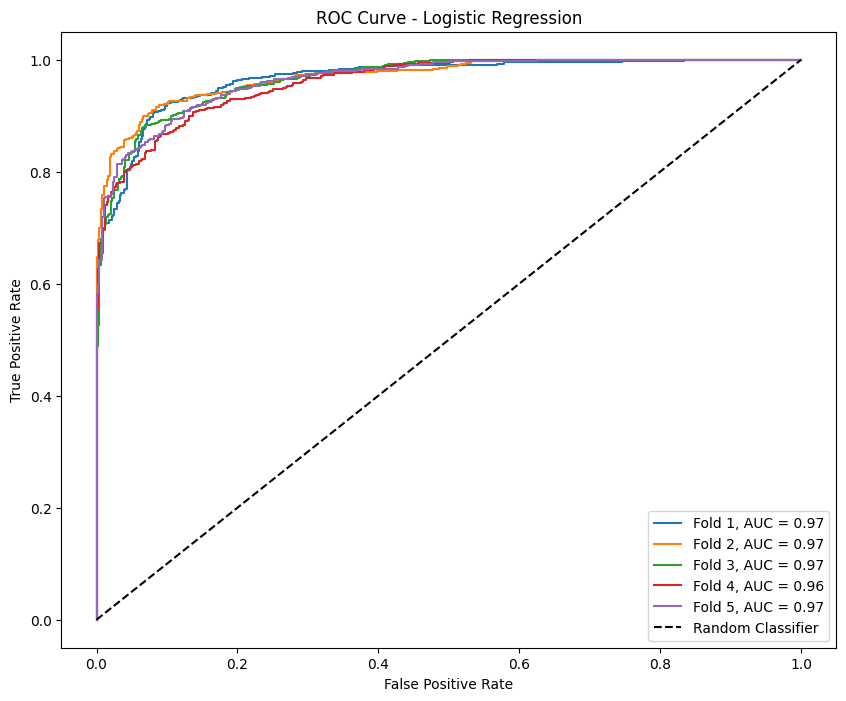

[0.9668590076071922, 0.9702876525263204, 0.9661807261807261, 0.9607399425287355, 0.9651646903820816]
Average AUC: 0.9658464038450113


In [21]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Binary label for logistic regression
y_train_binary = (y_train > 1000).astype(int)

# Initialize lists to store AUC values
auc_values = []

plt.figure(figsize=(10, 8))

kf = KFold(n_splits=5)
for i, fold in enumerate(kf.split(X_train, y_train_binary)):
  X_train_kf, y_train_kf, X_test_kf, y_test_kf = fold
  
  # Train the model
  model_logistic_regression.fit(X_train_kf, y_train_kf)

  # Make predictions
  y_pred_kf = model_logistic_regression.predict(X_test_kf)

  print(compute_rmse(y_test_kf, y_pred_kf))

  # Compute the ROC curve
  y_pred_kf_prob = model_logistic_regression.predict_prob(X_test_kf)[:, 1]
  fpr, tpr, _ = roc_curve(y_test_kf, y_pred_kf_prob)
  auc = roc_auc_score(y_test_kf, y_pred_kf_prob)
  auc_values.append(auc)
  
  # Plot the ROC curve for the current fold
  plt.plot(fpr, tpr, label=f'Fold {len(auc_values)}, AUC = {auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='best')
plt.show()

print(auc_values)
avg_auc = np.mean(auc_values)
print(f"Average AUC: {avg_auc}")

## (g) ROC Curve - Logistic Regression

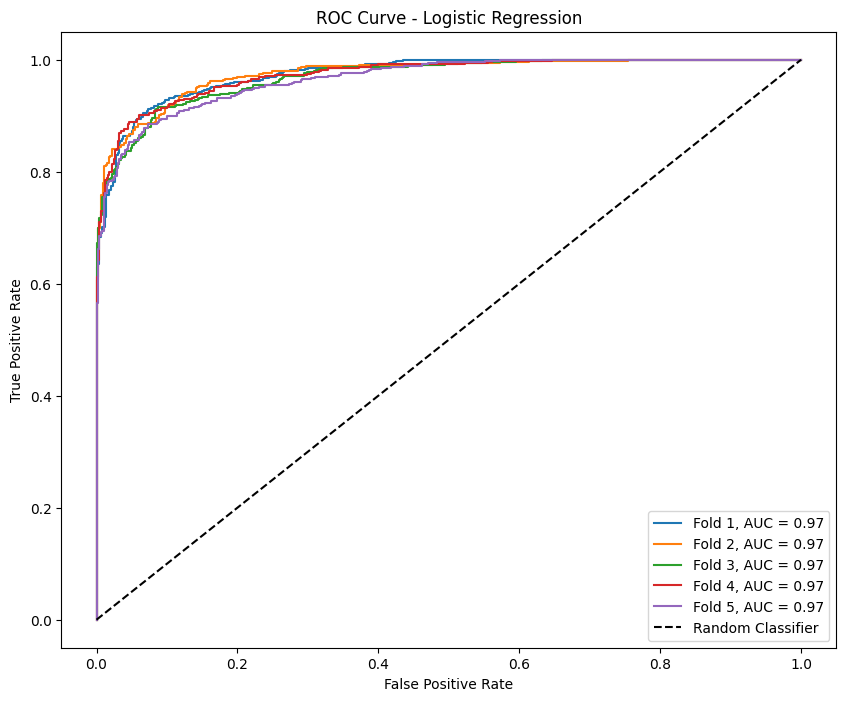

Average AUC: 0.9715359351951204


In [22]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# print(kf.split(X_train))

# Initialize the logistic regression model from sklearn
sklearn_logistic_model = SklearnLogisticRegression()

# Initialize lists to store AUC values
auc_values = []

plt.figure(figsize=(10, 8))

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.values[train_index], X_train.values[val_index]
    y_fold_train, y_fold_val = y_train_binary.values[train_index], y_train_binary.values[val_index]
    
    # Train the sklearn logistic regression model
    sklearn_logistic_model.fit(X_fold_train, y_fold_train)
    
    # Predict probabilities for the validation set
    y_fold_probs = sklearn_logistic_model.predict_proba(X_fold_val)[:, 1]
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_probs)
    auc = roc_auc_score(y_fold_val, y_fold_probs)
    auc_values.append(auc)
    
    # Plot the ROC curve for the current fold
    plt.plot(fpr, tpr, label=f'Fold {len(auc_values)}, AUC = {auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='best')
plt.show()

avg_auc = np.mean(auc_values)
print(f"Average AUC: {avg_auc}")

## (h) Inference - Linear and Logistic Regression